Consolidate the folds into a single set of results.

In particular, compute the mean and standard deviations of the models in the accuracy, recall and F-score. 

In [1]:
import os
from glob import glob

import numpy as np
import tensorflow as tf

import ScalableLib.classifier.Multiband as multiband
import ScalableLib.base.plot as plot


2024-09-09 09:13:34.903901: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 09:13:34.903933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 09:13:34.904993: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 09:13:34.911277: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-09 09:13:35.869491: W tensorflow/compiler/tf2

In [2]:
# To reset cuda
# sudo rmmod nvidia_uvm
# sudo modprobe nvidia_uvm
# To see if the system regognises the GPU
device = 0
devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(devices[device], 'GPU')
tf.config.experimental.set_memory_growth(device=devices[device], enable=True)


Read the Results folder.

In [3]:
survey = 'ZTF'
path = os.path.join('../../03_TrainModels/', survey, 'Results/Fold_*',)
folds = glob(path)
folds.sort()
folds

['../../03_TrainModels/ZTF/Results/Fold_1',
 '../../03_TrainModels/ZTF/Results/Fold_2',
 '../../03_TrainModels/ZTF/Results/Fold_3',
 '../../03_TrainModels/ZTF/Results/Fold_4',
 '../../03_TrainModels/ZTF/Results/Fold_5',
 '../../03_TrainModels/ZTF/Results/Fold_6',
 '../../03_TrainModels/ZTF/Results/Fold_7']

In [4]:
folder_name = 'Results'
path = os.path.join('.', folder_name,'')
if not os.path.exists(path):
    os.mkdir(path)

For each fold, read the models and evaluate on the test set. Save the results

In [5]:
label_order = ['SNIa', 'QSO','AGN', 'Blazar', 'YSO', 'CV/Nova', 'RRL', 'LPV', 'E', ]

In [6]:
# Containers to store the results
reports_folds = []
cm_folds = []
regressions = []
for fold in folds:
    tf.keras.backend.clear_session()
    # Set the fold path
    base_dir = fold+'/'
    
    # Get the last run
    path_runs_folder = os.path.join(base_dir, 'Models', '*')
    path_runs = glob(path_runs_folder)
    path_runs.sort()
    path_run = path_runs[-1]    
    
    path_preprocess = fold.replace('/03_TrainModels/', '/02_CreateRecords/').replace('/Results/', '/Folds/')
    test_files = os.path.join(path_preprocess, 'test/*.tfrecord')
    path_preprocess = os.path.join(path_preprocess, 'metadata_preprocess.json')    

    
    new = multiband.Network()    
    settings_path = os.path.join(path_run, 'all_settings.json')

    fold_name = fold.split('/')[-1]
    write_path = os.path.join('./Results', fold_name+'_Results.dat')
    
    # Get weights path
    run = path_run.split('/')[-1]
    weights_path = os.path.join(fold, 'Models', run)
    new.run_test(settings_path, test_files, weights_path, df_paths = write_path);
    
    
    
    result_path = os.path.join('./Results', fold.split('/')[-1]+'_Results.dat')
    
    # From the results file, read the data and compute the classification scores
    report_fold = plot.compute_classification_report(result_path)
    reports_folds.append(report_fold)
    # From the results file, read the data and compute the confussion matrix and the respective  labels 
    cm_fold = plot.compute_confussion_matrices(result_path, num_classes=new.num_classes, trans=new.trans, labels=label_order)
    cm_folds.append(cm_fold)
    # Extract the regression metrics
    regression = plot.compute_regression(result_path, new.physical_params)
    regressions.append(regression)

2024-09-09 09:13:38.074305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10272 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:02:00.0, compute capability: 8.6


../../02_CreateRecords/ZTF/Folds/Fold_1/test/*.tfrecord


2024-09-09 09:13:39.148239: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-09-09 09:13:53.374114: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


              precision    recall  f1-score   support

         AGN       0.66      0.60      0.63       484
      Blazar       0.74      0.59      0.65       218
     CV/Nova       0.83      0.79      0.81       152
           E       0.93      0.93      0.93      2000
         LPV       0.99      1.00      1.00      1863
         QSO       0.88      0.91      0.90      2000
         RRL       0.93      0.94      0.94      2000
        SNIa       1.00      0.96      0.98       101
         YSO       0.85      0.79      0.82       159

    accuracy                           0.91      8977
   macro avg       0.87      0.83      0.85      8977
weighted avg       0.91      0.91      0.91      8977

{'R2': {'T_eff': 0.7443020182352815, 'Radius': 0.7658989300746264}, 'RMSE': {'T_eff': 494.8877, 'Radius': 9.019236}}
../../02_CreateRecords/ZTF/Folds/Fold_2/test/*.tfrecord
              precision    recall  f1-score   support

         AGN       0.68      0.60      0.63       484
      Blazar 

In [7]:
median, delta_up, delta_down = plot.obtain_accumulated_metrics(reports_folds, metric='median', label_order=label_order)
display(median)
display(delta_up)
display(delta_down)

,SNIa,QSO,AGN,Blazar,YSO,CV/Nova,RRL,LPV,E
precision,1.00,0.88,0.65,0.74,0.85,0.81,0.94,0.99,0.92
recall,0.96,0.91,0.60,0.57,0.77,0.81,0.93,1.00,0.94
f1-score,0.98,0.90,0.62,0.65,0.81,0.81,0.94,0.99,0.93
support,101.00,2000.00,484.00,218.00,159.00,152.00,2000.00,1863.00,2000.00


,SNIa,QSO,AGN,Blazar,YSO,CV/Nova,RRL,LPV,E
precision,0.000000,0.000677,0.021861,0.007737,0.001695,0.012097,0.002012,0.000787,0.002246
recall,0.004950,0.002750,0.001033,0.009174,0.009434,0.006579,0.005250,0.000537,0.000250
f1-score,0.000101,0.001646,0.010288,0.003412,0.009546,0.002415,0.001551,0.000269,0.001844
support,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,SNIa,QSO,AGN,Blazar,YSO,CV/Nova,RRL,LPV,E
precision,0.000000,0.000098,0.005104,0.019336,0.006302,0.024729,0.001799,0.000010,0.001399
recall,0.019802,0.001000,0.004132,0.009174,0.012579,0.009868,0.001500,0.001074,0.000750
f1-score,0.010437,0.000797,0.001895,0.014304,0.010565,0.008213,0.002409,0.000539,0.000723
support,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
np.round(median.loc['f1-score'].mean(),3)

0.848

<Figure size 640x480 with 0 Axes>

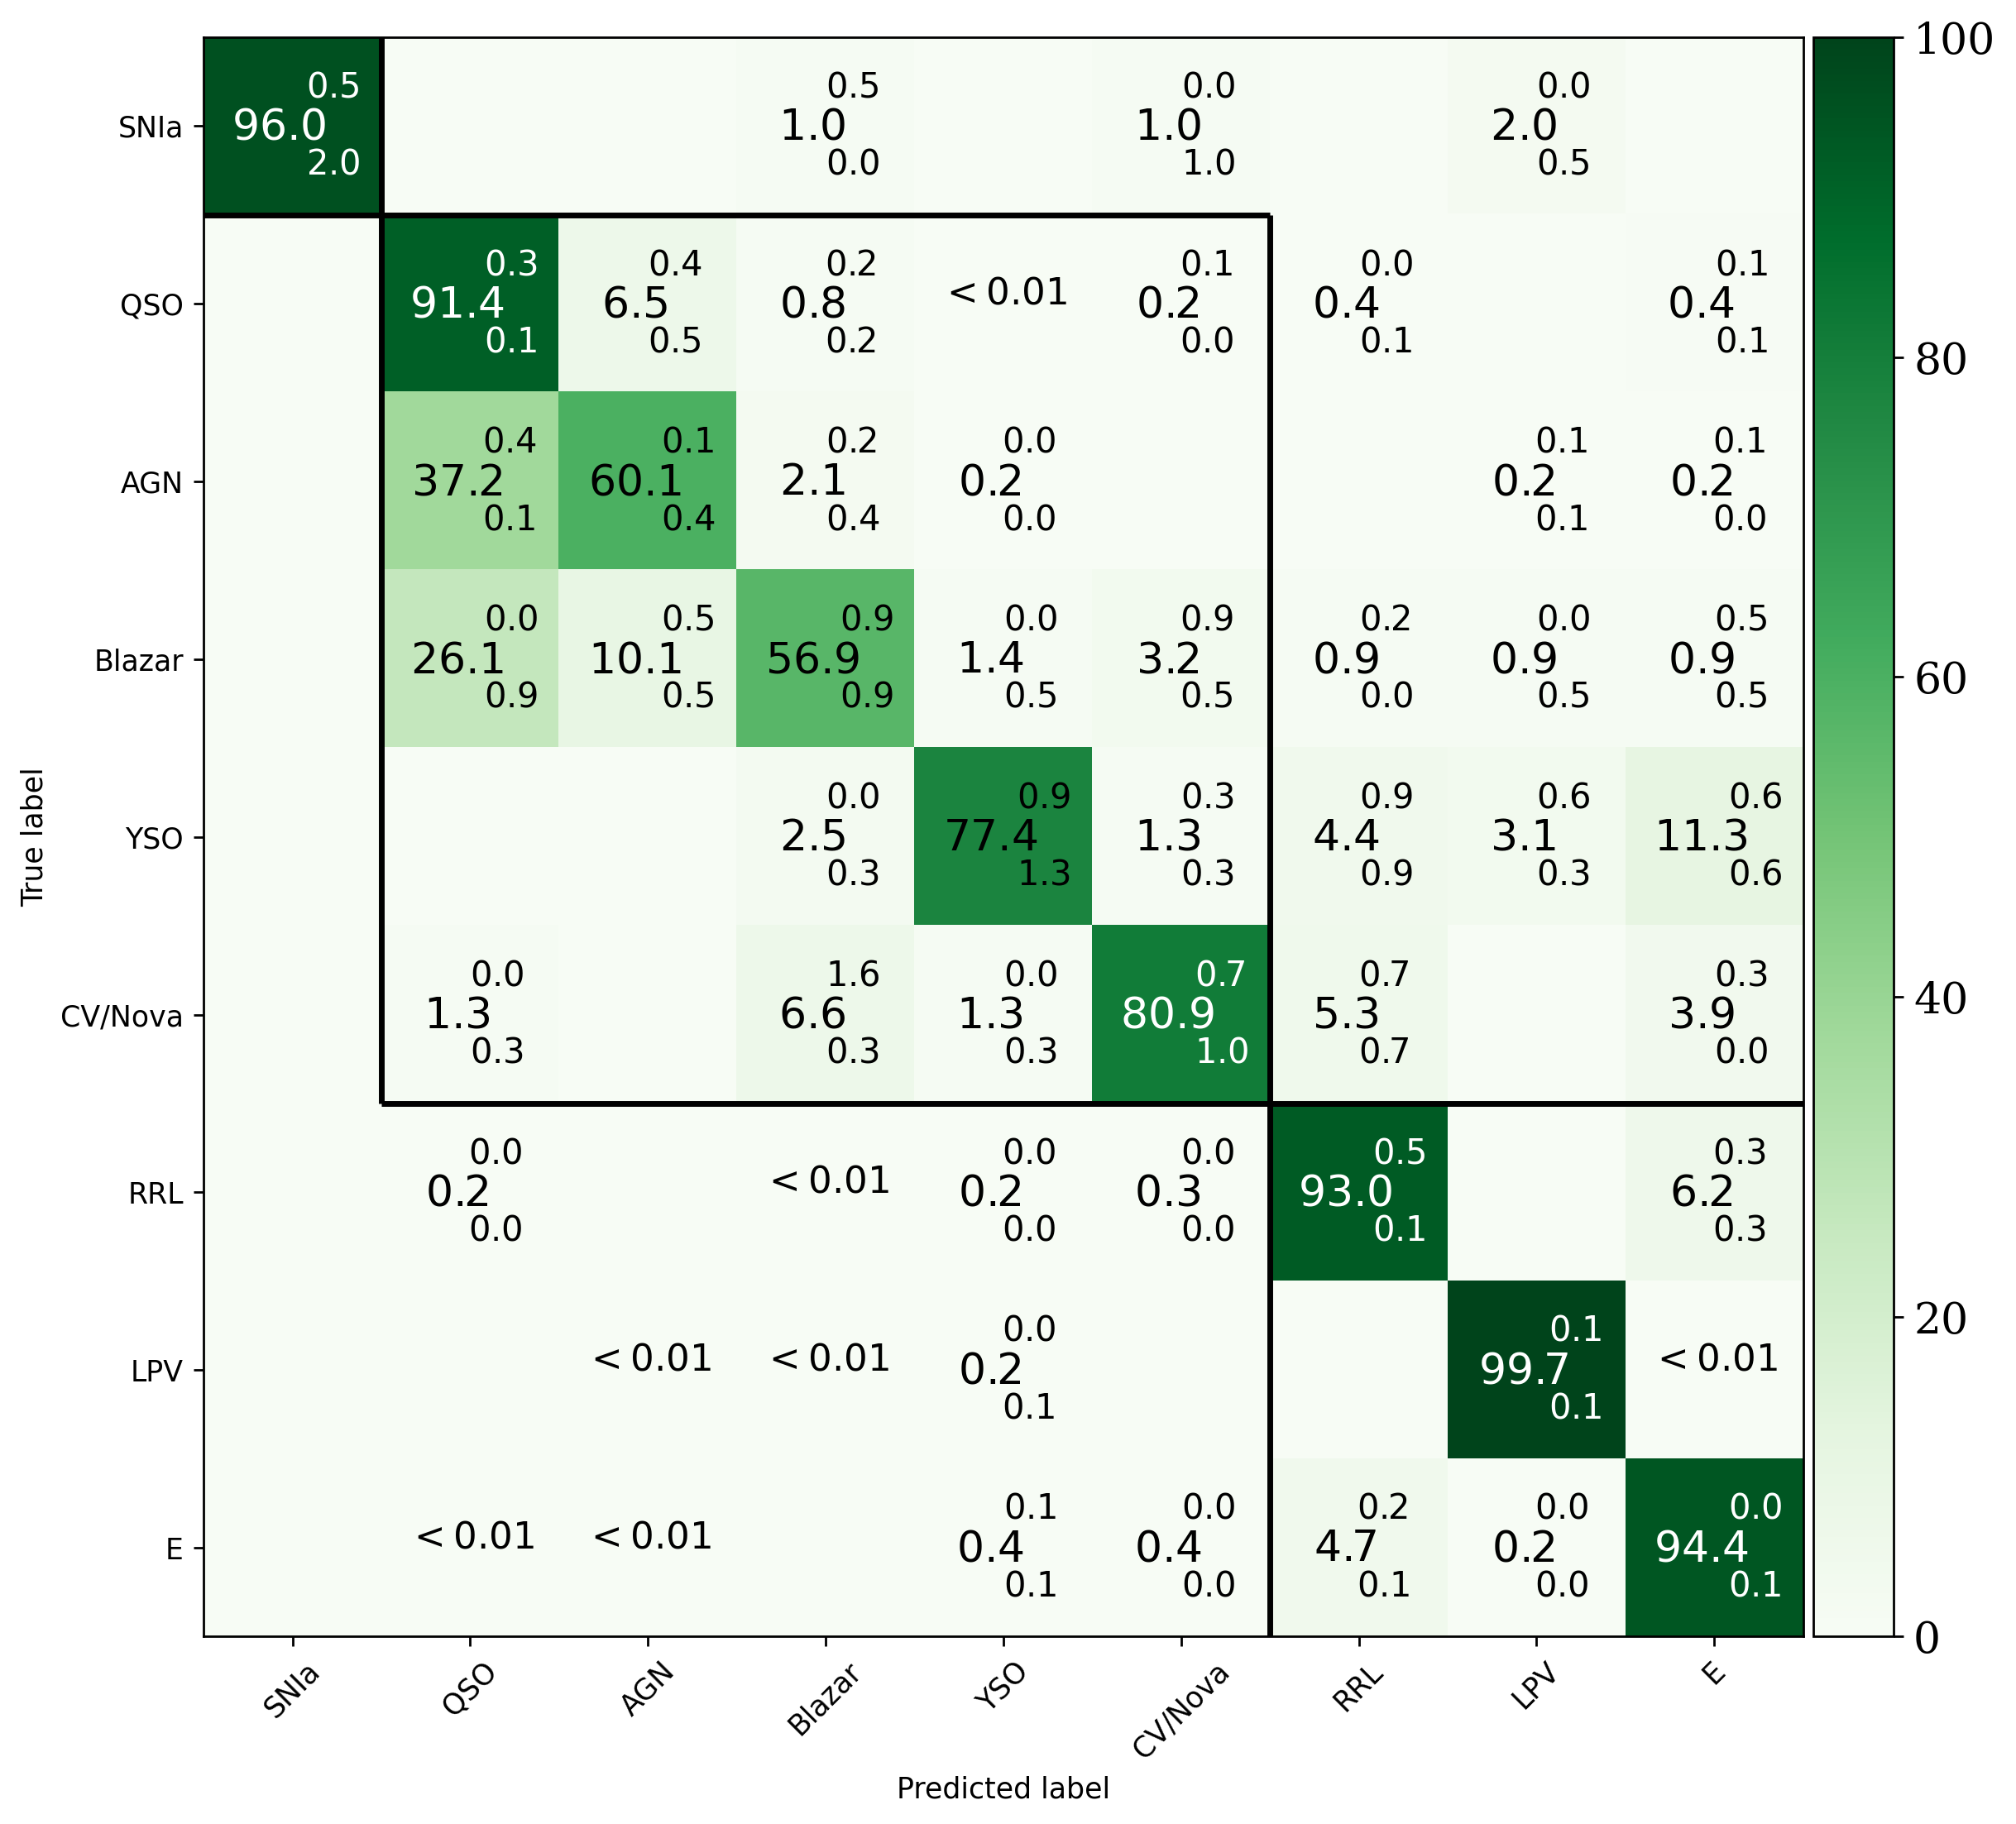

In [9]:
statistic = 'median'
img_path = './'+survey+'_'+statistic+'_c.pdf'
plot.plot_confusion_matrix(cm_folds, labels_=label_order, survey='ZTF', statistic=statistic, save_path=img_path)

In [10]:
accuracies = [reports_folds[i]['accuracy'] for i in range(len(reports_folds))]
np.round(np.median(accuracies),4), np.round(np.mean(accuracies),4)


(0.9124, 0.9124)

In [11]:
macro_avg_recall = [reports_folds[i]['macro avg']['recall'] for i in range(len(reports_folds))]
np.round(np.median(macro_avg_recall),4), np.round(np.mean(macro_avg_recall),4)

(0.8318, 0.8314)

In [12]:
regression_metrics = plot.obtain_accumulated_regressions(regressions, metric='median')
print('median')
display(regression_metrics[0])
print('75-percentile')
display(regression_metrics[1])
print('25-percentile')
display(regression_metrics[2])


median


,R2,RMSE,MAPE
T_eff,0.744302,493.518377,0.061505
Radius,0.763596,9.513106,0.718878


75-percentile


,R2,RMSE,MAPE
T_eff,0.002493,1.093440,0.000074
Radius,0.002513,0.201034,0.031638


25-percentile


,R2,RMSE,MAPE
T_eff,0.000443,2.745852,0.000808
Radius,0.000600,0.247287,0.023890
